# Using manipulated data

In [2]:
%matplotlib inline

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tick
from tick.base import TimeFunction
from tick.hawkes import SimuHawkesExpKernels
from tick.plot import plot_point_process
from tick.hawkes import HawkesExpKern
from tick.plot import plot_hawkes_kernel_norms
import os
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

In [4]:
# Set global font properties
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Palatino', 'Georgia']
plt.rcParams['font.size'] = 14

In [5]:
def simulate_markov_chain(P, num_steps, start_state=0, sc = 0.01):
    """
    Simulate a Markov chain given a transition matrix P.
    
    Parameters:
    - P: Transition matrix (2D numpy array)
    - num_steps: Number of steps to simulate
    - start_state: Initial state (default is 0)
    
    Returns:
    - List of states over time
    """
    np.random.seed(0)
    # Ensure the matrix is a numpy array
    P = np.array(P)
    
    # Initialize the current state and the list to store the sequence of states
    current_state = start_state
    states = [current_state]
    Values = np.array([-sc, sc])
    # Simulate the Markov chain
    for _ in range(num_steps):
        next_state = np.random.choice(len(P), p=P[current_state])
        states.append(next_state)
        current_state = next_state
    val = [Values[s] for s in states]    
    return val

## Read data

from 2020 paper we have <br/>

|     |  λ | α   |  β | Emp. E[N([0, 1])] |pdd |puu |σ| a∗|
| --- | --- | --- | --- | --- |--- |--- |--- |--- |
| AMZN | 0.6443 | 653.7524 | 1556.1702 | 1.1110|  0.4635| 0.4576| 0.0046 |−2.7373 × 10−5|

In this case, −δ will be state one, and δ with be state two.


standard parameter from the above table are not stable

In [6]:
stock = 'GOOG'
lob_level = 1
p = 'lobdataread'
msgfile = os.path.join(os.getcwd(), f'{p}' ,"data", f'{stock}_2012-06-21_34200000_57600000_message_{lob_level}.csv')
obfile =  os.path.join(os.getcwd(), f'{p}' ,"data", f'{stock}_2012-06-21_34200000_57600000_orderbook_{lob_level}.csv')
df1=pd.read_csv(msgfile, sep=',', header=None, 
        names=['time', 'type', 'ord_id', 'size', 'price', 'dir'],
        dtype={'time':np.float64, 'type':np.int32, 'ord_id':np.int32, 
               'size':np.int64, 'price':np.int64, 'dir':np.int32})

df2=pd.read_csv(obfile, sep=',', header=None, 
        names=['ask_prc_L1', 'ask_sz_L1', 'bid_prc_L1', 'bid_sz_L1'],
        dtype={'ask_prc_L1':np.float64, 'ask_sz_L1':np.int64, 'bid_prc_L1':np.float64, 'bid_sz_L1':np.int64})

df3 = pd.concat([df1, df2], axis=1)
df3 = df3.drop_duplicates(subset='time', keep='first')
df3['mid_price'] = (df3['ask_prc_L1'] + df3['bid_prc_L1'])/2
df3['datetime'] = pd.to_timedelta(df3['time'], unit='s') + pd.Timestamp("2012-06-21")
df3 = df3[(df3['datetime'].dt.time >= pd.Timestamp('2012-06-21 09:46:00').time()) & 
                 (df3['datetime'].dt.time <= pd.Timestamp('2012-06-21 15:44:00').time())]

In [7]:
df = df3[['time', 'datetime', 'mid_price']].copy()
df['mid_price'] = df['mid_price']/10000 
df.loc[:, 'mid_price'] = df['mid_price'] - df['mid_price'].iloc[0]
df.loc[:, 'time'] = df['time'] - df['time'].iloc[0]
df.reset_index(drop=True, inplace=True)
df['mid_diff'] = df['mid_price'].diff()
# Replace NaN with 0 at the beginning
df['mid_diff'].fillna(0, inplace=True)
threshold = 1e-6
df = df[df['mid_diff'].abs() >= threshold]
df.reset_index(drop=True, inplace=True)

In [8]:
df.head(2)

,time,datetime,mid_price,mid_diff
0,1.597966,2012-06-21 09:46:02.122630873,-0.005,-0.005
1,4.126696,2012-06-21 09:46:04.651360767,0.110,0.115


In [9]:
n_state = [3, 3]
n_state_neg = n_state[0]
n_state_pos = n_state[1]
n_state_tot = sum(n_state)

# Split data into positive and negative
df_positive = df[df['mid_diff'] >= 0]
df_negative = df[df['mid_diff'] < 0]


# Calculate quantiles for positive and negative data
quantiles_positive = df_positive['mid_diff'].quantile(list(np.linspace(0, 1, n_state_pos + 1 )[1:-1])).tolist()
quantiles_negative = df_negative['mid_diff'].quantile(list(np.linspace(0, 1, n_state_neg + 1 )[1:-1])).tolist()

# Remove duplicates
quantiles_positive = sorted(list(set(quantiles_positive)))
quantiles_negative = sorted(list(set(quantiles_negative)))

# Calculate state values a(i) for positive data
a_positive = []
a_positive.append(df_positive[(df_positive['mid_diff'] <= quantiles_positive[0])]['mid_diff'].mean())
for i in range(len(quantiles_positive) - 1):
    a_positive.append(df_positive[(df_positive['mid_diff'] > quantiles_positive[i]) & 
                                  (df_positive['mid_diff'] <= quantiles_positive[i+1])]['mid_diff'].mean())
a_positive.append(df_positive[(df_positive['mid_diff'] > quantiles_positive[-1])]['mid_diff'].mean())


# Calculate state values a(i) for negative data
a_negative = []
a_negative.append(df_negative[(df_negative['mid_diff'] < quantiles_negative[0])]['mid_diff'].mean())
for i in range(len(quantiles_negative) - 1):
    a_negative.append(df_negative[(df_negative['mid_diff'] >= quantiles_negative[i]) & 
                                  (df_negative['mid_diff'] < quantiles_negative[i+1])]['mid_diff'].mean())
a_negative.append(df_negative[(df_negative['mid_diff'] >= quantiles_negative[-1])]['mid_diff'].mean())


In [10]:
plt.figure(figsize=(10,5))
plt.hist(df_positive["mid_diff"], bins=30, alpha=0.7, label='Histogram of positive mid_diff')

# Add vertical lines for quantiles
for q in quantiles_positive:
    plt.axvline(q, color='r', linestyle='--', label=f'Quantile: {q:.4f}')

# Add vertical lines for the specified values
for v in a_positive:
    plt.axvline(v, color='g', linestyle=':', label=f'Value: {v:.4f}')

plt.legend()
plt.xlabel('mid_diff')
plt.ylabel('Frequency')
plt.title('Histogram of mid_diff with Quantiles and Specified Values')
plt.tight_layout()
plt.show()

In [11]:
plt.figure(figsize=(10,5))
plt.hist(df_negative["mid_diff"], bins=30, alpha=0.7, label='Histogram of positive mid_diff')

# Add vertical lines for quantiles
for q in quantiles_negative:
    plt.axvline(q, color='r', linestyle='--', label=f'Quantile: {q:.4f}')

# Add vertical lines for the specified values
for v in a_negative:
    plt.axvline(v, color='g', linestyle=':', label=f'Value: {v:.4f}')

plt.legend()
plt.xlabel('mid_diff')
plt.ylabel('Frequency')
plt.title('Histogram of mid_diff with Quantiles and Specified Values')
plt.tight_layout()
plt.show()

In [12]:
# Assign states to price changes
df['state'] = np.nan

# Assign states for negative data
df.loc[df['mid_diff'] < quantiles_negative[0], 'state'] = 0
df.loc[df['mid_diff'] < quantiles_negative[0], 'state_value'] = a_negative[0]
for i in range(1, len(quantiles_negative)):
    df.loc[(df['mid_diff'] >= quantiles_negative[i-1]) & (df['mid_diff'] < quantiles_negative[i]), 'state'] = i
    df.loc[(df['mid_diff'] >= quantiles_negative[i-1]) & (df['mid_diff'] < quantiles_negative[i]), 'state_value'] = a_negative[i]
df.loc[(df['mid_diff'] >= quantiles_negative[-1])  & (df['mid_diff'] < 0), 'state'] = len(quantiles_negative)
df.loc[(df['mid_diff'] >= quantiles_negative[-1])  & (df['mid_diff'] < 0), 'state_value'] = a_negative[-1]
    
    
start_state_pos = len(a_negative) 
df.loc[(df['mid_diff'] <= quantiles_positive[0]) & (df['mid_diff'] >= 0) , 'state'] = start_state_pos 
df.loc[(df['mid_diff'] <= quantiles_positive[0]) & (df['mid_diff'] >= 0), 'state_value'] = a_positive[0]
for i in range(1, len(quantiles_positive)):
    df.loc[(df['mid_diff'] > quantiles_positive[i - 1]) & (df['mid_diff'] <= quantiles_positive[i]), 'state'] = start_state_pos + i
    df.loc[(df['mid_diff'] > quantiles_positive[i - 1]) & (df['mid_diff'] <= quantiles_positive[i]), 'state_value'] = a_positive[i]
df.loc[df['mid_diff'] > quantiles_positive[-1], 'state'] = start_state_pos + len(quantiles_positive)
df.loc[df['mid_diff'] > quantiles_positive[-1], 'state_value'] =  a_positive[-1]
df['state'] = df['state'].astype(int)

In [13]:
df.head()

,time,datetime,mid_price,mid_diff,state,state_value
0,1.597966,2012-06-21 09:46:02.122630873,-0.005,-0.005,2,-0.006568
1,4.126696,2012-06-21 09:46:04.651360767,0.110,0.115,5,0.068814
2,4.127149,2012-06-21 09:46:04.651813194,-0.005,-0.115,0,-0.066128
3,4.127233,2012-06-21 09:46:04.651896918,0.105,0.110,5,0.068814
4,4.127465,2012-06-21 09:46:04.652129178,-0.005,-0.110,0,-0.066128


In [14]:
df.isnull().any()

time           False
datetime       False
mid_price      False
mid_diff       False
state          False
state_value    False
dtype: bool

In [15]:
df = df[['time', 'datetime', 'mid_diff', 'mid_price', 'state', 'state_value']]

In [16]:
df.head(2)

,time,datetime,mid_diff,mid_price,state,state_value
0,1.597966,2012-06-21 09:46:02.122630873,-0.005,-0.005,2,-0.006568
1,4.126696,2012-06-21 09:46:04.651360767,0.115,0.110,5,0.068814


In [17]:
%matplotlib inline
#df.mid_price.plot()

In [18]:
%%capture
timestamps_list = [df['time'].values]
best_score = -1e100
dd = []
decay_candidates = np.linspace(0, 5000, 5000)
best_decay = 0
for i, decay in enumerate(decay_candidates):
    hawkes_learner = HawkesExpKern(decay, verbose=False, max_iter=10000, tol=1e-10)
    hawkes_learner.fit(timestamps_list)

    hawkes_score = hawkes_learner.score()
    dd.append(hawkes_score)
    if hawkes_score > best_score:
        #print('obtained {}\n with {}\n'.format(hawkes_score, decay))
        best_hawkes = hawkes_learner
        best_score = hawkes_score
        best_decay = decay

In [19]:
fig, ax = plt.subplots(1,1, figsize = (15, 5))
ax.plot(decay_candidates, dd)

In [20]:
print(f'n = {best_hawkes.n_nodes}',
      f'mu = {best_hawkes.baseline}', 
      f'alpha = {best_hawkes.adjacency}', '\n'
      f'beta = {best_decay}, alpha_p = {best_hawkes.adjacency * best_decay}, score = {best_score}')

n = 1 mu = [0.45509476] alpha = [[0.44611705]] 
beta = 1620.8104052026015, alpha_p = [[723.07115039]]


## Markov Process

In [21]:
#ts = hw.timestamps[0] #ts
# Compute total milliseconds between 9:45 and 15:45
# hours_diff = 15 + 45/60 - (9 + 45/60)  # 6 hours
#total_milliseconds = hours_diff * 60 * 60 * 1000  # Convert hours to milliseconds

# Rescale the values in ts
#ts_rescaled = (ts - ts.min()) / (ts.max() - ts.min()) * total_milliseconds

# Convert ts_rescaled to datetime
#start_time = pd.Timestamp('2012-06-21 00:00:00') 
#datetime_array = start_time + pd.to_timedelta(ts, unit='s')

# Convert ts_rescaled to seconds
#ts_seconds1 = ts / 1

# Create a DataFrame
#df = pd.DataFrame({
#    'datetime': datetime_array,
#    'time': ts_seconds1
#})

In [22]:
#pdd = 0.46530078
#puu = 0.45586017
#P = [[pdd, 1-pdd],
#    [1-puu, puu]]

In [23]:
#num_steps = len(ts)
#start_state = 0
#X = np.array(simulate_markov_chain(P, num_steps, start_state))[1:]
#S = np.cumsum(X)
#
#df['jump'] = range(1, len(df) + 1)
#df['mid_diff'] = X
#df['mid_price'] = S
#df = df[['time', 'datetime', 'mid_price', 'mid_diff']]

In [24]:
#S = df.mid_price
#Sx = np.cumsum(np.ones_like(df.mid_price))
#Si = np.cumsum(-np.ones_like(df.mid_price))
#fig, ax = plt.subplots(1, 1, figsize=(20, 4))
#ax.plot(ts, S, ".-", label='Sample Data')
#ax.plot(ts, Sx, "-", label='Ideal Max')
#ax.plot(ts, Si, "-", label='Ideal Min')


# Add labels and title
#ax.set_xlabel('Time')
#ax.set_ylabel('Stock')
#ax.set_title('Time vs Value')
#ax.legend()

# Display the plot
#plt.show()

## Read data

In [25]:
#df.head()

## Transition probability

In [26]:
# Initialize transition matrix
transition_matrix = np.zeros((n_state_tot, n_state_tot))

# Compute transitions
for i in range(len(df['state']) - 1):
    current_state = df['state'].iloc[i]
    next_state = df['state'].iloc[i + 1]
    transition_matrix[current_state][next_state] += 1

# Normalize to get probabilities
transition_probs = transition_matrix / transition_matrix.sum(axis=1)[:, None]
print(transition_probs)

[[0.106914   0.12209106 0.17335582 0.10016863 0.09376054 0.40370995]
 [0.12272911 0.14089625 0.18974566 0.12071054 0.33831247 0.08760597]
 [0.12434949 0.12161052 0.32484251 0.26869351 0.08107368 0.07943029]
 [0.08265425 0.10593714 0.26949942 0.30355064 0.11816065 0.1201979 ]
 [0.1734609  0.32113145 0.12562396 0.15266223 0.11855241 0.10856905]
 [0.44200743 0.06914498 0.0936803  0.1669145  0.11226766 0.11598513]]


In [27]:
# Assuming transition_probs is your transition matrix
P = transition_probs

# Create a matrix where each row is P - I
matrix = P.T - np.eye(P.shape[0])

# Replace the last row with ones to account for the probability constraint
matrix[-1, :] = 1

# Create the target vector, with a 1 at the end for the probability constraint
target = np.zeros(P.shape[0])
target[-1] = 1

# Solve the linear system
stationary_probs = np.linalg.solve(matrix, target)

print(stationary_probs)
print("================")
print(stationary_probs @ P)
print("================")
print(np.sum(stationary_probs))

[0.16825039 0.1405676  0.20710085 0.194962   0.13647472 0.15264444]
[0.16825039 0.1405676  0.20710085 0.194962   0.13647472 0.15264444]
1.0


## Hawkes process

In [28]:
#best_hawkes = hw
#best_decay = decay

In [29]:
#best_hawkes.n_nodes, best_hawkes.baseline, best_hawkes.adjacency, best_decay
#best_hawkes.coeffs 

## General compound

\begin{equation}
v(i) = b(i)^2 + \sum_{j \in S} (g(j) - g(i))^2 P(i, j) - 2b(i) \sum_{j \in S} (g(j) - g(i)) P(i, j)
\end{equation}

In [30]:
def compute_v(b, g, P):
    """
    Compute v based on the given formula.
    
    Parameters:
    - i: the current state
    - b: a function or dictionary that gives b(i) for each i
    - g: a function or dictionary that gives g(i) for each i
    - P: a 2D array or dictionary of dictionaries that gives P(i, j) for each pair i, j    
    Returns:
    - v
    """
    v = np.zeros(b.shape)
    S = np.array([i for i in range(len(b))])
    for i in range(len(b)):
        term1 = b[i]**2
        term2 = np.sum([(g[j] - g[i])**2 * P[i][j] for j in S])
        term3 = -2 * b[i] * np.sum([(g[j] - g[i]) * P[i][j] for j in S])
        v[i] = term1 + term2 + term3
    
    return v

In [31]:
# np.dot(stationary_probs, transition_probs), stationary_probs

In [32]:
lam = best_hawkes.baseline
alpha = best_hawkes.adjacency
beta = best_decay
mu_hat = alpha# (alpha*beta)/beta
a = a_negative + a_positive
a_star = np.dot(stationary_probs, a)
b = a - a_star
# # compute g 
P = transition_probs
Pi = np.tile(stationary_probs, (len(stationary_probs), 1))
# Identity matrix
I = np.eye(n_state_tot)
# Compute the inverse of P + Pi - I
g = np.linalg.inv(P + Pi - I)@ b
v =compute_v(b, g, P) 
sigma_2 = np.dot(stationary_probs, v)
sigma = np.sqrt(sigma_2)
sigma_star = sigma * np.sqrt(lam / (1 - mu_hat))

In [33]:
transition_probs, sigma, a_star, mu_hat, lam

(array([[0.106914  , 0.12209106, 0.17335582, 0.10016863, 0.09376054,
         0.40370995],
        [0.12272911, 0.14089625, 0.18974566, 0.12071054, 0.33831247,
         0.08760597],
        [0.12434949, 0.12161052, 0.32484251, 0.26869351, 0.08107368,
         0.07943029],
        [0.08265425, 0.10593714, 0.26949942, 0.30355064, 0.11816065,
         0.1201979 ],
        [0.1734609 , 0.32113145, 0.12562396, 0.15266223, 0.11855241,
         0.10856905],
        [0.44200743, 0.06914498, 0.0936803 , 0.1669145 , 0.11226766,
         0.11598513]]),
 0.03041608011688308,
 -0.0006430144525909067,
 array([[0.44611705]]),
 array([0.45509476]))

In [44]:
"& ".join([(f'{x:.3f}') for x in a])

'-0.066& -0.021& -0.007& 0.006& 0.022& 0.069'

In [45]:
"& ".join([(f'{x:.3f}') for x in stationary_probs.tolist() + [sigma] + mu_hat[0].tolist()])

'0.168& 0.141& 0.207& 0.195& 0.136& 0.153& 0.030& 0.446'

In [35]:
df['mid_price2'] = np.cumsum(df['state_value'])
df['datetime'] = pd.to_datetime(df['datetime'])

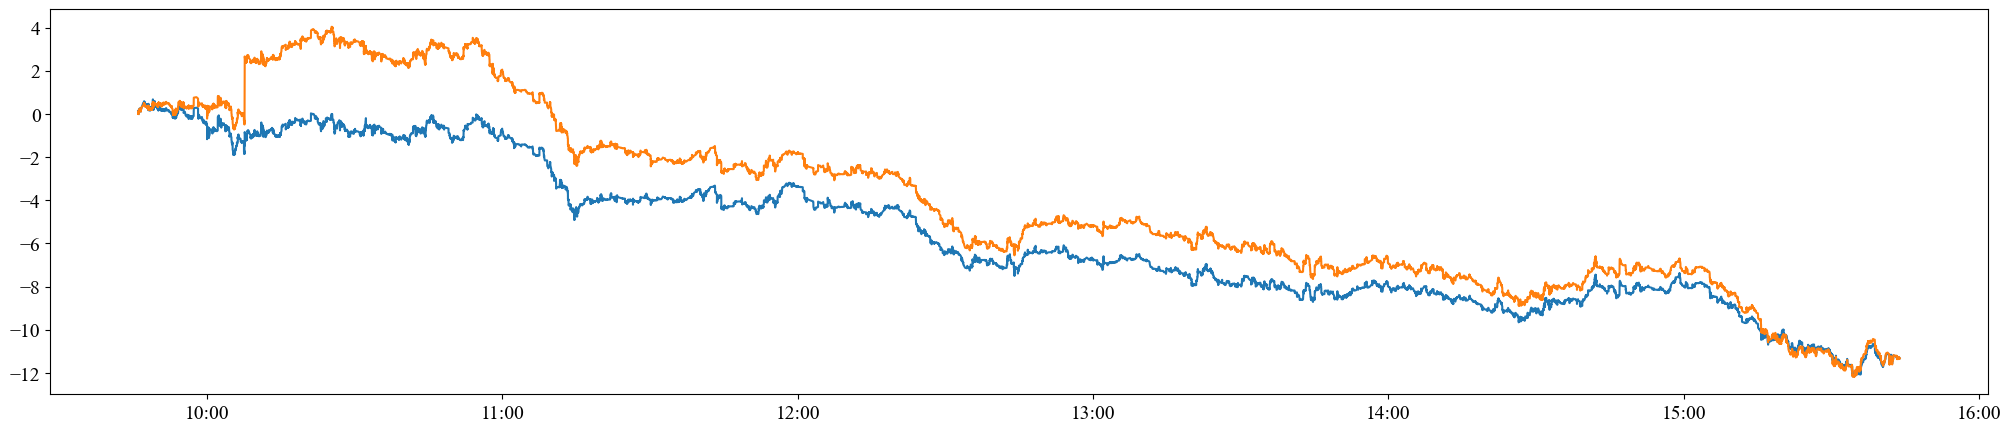

In [36]:
%matplotlib inline
import matplotlib
fig, ax = plt.subplots(1,1, figsize  = (25,5))
ax.plot(df.datetime, df.mid_price)
ax.plot(df.datetime, df.mid_price2)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
#ax.set_xlim([0, 21400])
#ax.set_ylim([-5, 2])

In [37]:
df.tail()

,time,datetime,mid_diff,mid_price,state,state_value,mid_price2
17619,21465.760957,2012-06-21 15:43:46.285621890,0.025,-11.330,4,0.022129,-11.339064
17620,21466.552304,2012-06-21 15:43:47.076968793,0.050,-11.280,5,0.068814,-11.270250
17621,21467.974032,2012-06-21 15:43:48.498696158,-0.055,-11.335,0,-0.066128,-11.336378
17622,21470.576940,2012-06-21 15:43:51.101604846,-0.020,-11.355,1,-0.020751,-11.357129
17623,21473.319845,2012-06-21 15:43:53.844509201,0.020,-11.335,4,0.022129,-11.335000


In [71]:
def get_windows(df, a_star, lam, mu_hat, sigma):
    df_ = df
    df_ = df.set_index('datetime')
    windows = range(360, 1200, 20)  # This will create a list [10, 20, 30, ..., 800]
    std_values = {}
    std_values_theory = {}
    for window in windows:
        window = str(window) + 'S'
        mid_price =  df_['mid_price'].resample(window).apply(lambda x: x[-1] - x[0])
        jump = df_['mid_price'].resample(window).size() * a_star
        p_result = mid_price - jump

        std_value = p_result.dropna().std()
        std_values[window] = std_value
        n = float(window.replace('S',''))
        std_values_theory[window] = (np.sqrt(lam/(1 - mu_hat))*sigma*np.sqrt(n)).item()

    # Plotting the results
    #std_values, std_values_theory
    return std_value, std_values_theory
def mycurvefit(std_values, std_values_theory):
    x = [int(key[:-1]) for key in std_values.keys()]
    y = list(std_values.values())

    def func(x, a, b):
        return a * np.sqrt(x) + b
    params, covariance = curve_fit(func, x, y)
    a, b = params
    y_pred = func(x, a, b)
    y_true = list(std_values_theory.values())
    #y_signal = y
    return  y_pred, y_true

In [72]:
std_value, std_values_theory = get_windows(df, a_star, lam, mu_hat, sigma) 
y_pred, y_true = mycurvefit(std_values, std_values_theory)

In [73]:
mean_squared_error(y_true, y_pred, squared=False)

0.05737236325859343

In [74]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
def mycurvefit(std_values, std_values_theory):
    x = [int(key[:-1]) for key in std_values.keys()]
    y = list(std_values.values())

    def func(x, a, b):
        return a * np.sqrt(x) + b
    params, covariance = curve_fit(func, x, y)
    a, b = params
    y_pred = func(x, a, b)
    y_true = list(std_values_theory.values())
    #y_signal = y
    return  y_pred, y_true, a, b
y_pred, y_true, a, b = mycurvefit(std_values, std_values_theory)
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(rmse)
print("& ".join(map(str, [a, b, rmse])))

0.05737236325859343
0.031088433936130734& -0.041175684238591984& 0.05737236325859343


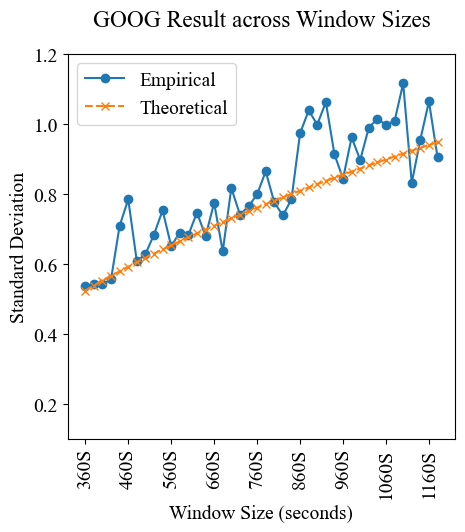

In [60]:
# Plotting the results
plt.figure(figsize=(5, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
#plt.plot(list(std_values_theory.keys()), func(x, a, b), linestyle='--', label='Fit')

plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('GOOG Result across Window Sizes', y= 1.05)
plt.legend()
n = 5
keys = list(std_values.keys())
plt.xticks(keys[::n], keys[::n], rotation=90)
plt.ylim([.1, 1.2])
#plt.grid(True)
plt.savefig("./pics/goog_std_ns.png", dpi=300, bbox_inches='tight')
plt.show()